# Loop 10 Analysis: Final Decision

## Key Questions:
1. Should we submit exp_010 ([16]) or keep exp_007 ([32,16])?
2. What is the CV-LB relationship telling us?
3. Is the target (0.0333) achievable?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.011081, 'lb': 0.09816, 'arch': '[128,128,64]'},
    {'exp': 'exp_001', 'cv': 0.012297, 'lb': 0.10649, 'arch': 'LightGBM'},
    {'exp': 'exp_003', 'cv': 0.010501, 'lb': 0.09719, 'arch': '[256,128,64]'},
    {'exp': 'exp_005', 'cv': 0.010430, 'lb': 0.09691, 'arch': '[256,128,64] 15-bag'},
    {'exp': 'exp_006', 'cv': 0.009749, 'lb': 0.09457, 'arch': '[64,32]'},
    {'exp': 'exp_007', 'cv': 0.009262, 'lb': 0.09316, 'arch': '[32,16]'},
]

df = pd.DataFrame(submissions)
df['ratio'] = df['lb'] / df['cv']
df['lb_improvement'] = df['lb'].diff() * -1  # Negative diff = improvement
df['cv_improvement'] = df['cv'].diff() * -1
print(df.to_string())

       exp        cv       lb                 arch      ratio  lb_improvement  cv_improvement
0  exp_000  0.011081  0.09816         [128,128,64]   8.858406             NaN             NaN
1  exp_001  0.012297  0.10649             LightGBM   8.659836        -0.00833       -0.001216
2  exp_003  0.010501  0.09719         [256,128,64]   9.255309         0.00930        0.001796
3  exp_005  0.010430  0.09691  [256,128,64] 15-bag   9.291467         0.00028        0.000071
4  exp_006  0.009749  0.09457              [64,32]   9.700482         0.00234        0.000681
5  exp_007  0.009262  0.09316              [32,16]  10.058303         0.00141        0.000487


In [2]:
# Analyze the CV-LB relationship
print('=== CV-LB Relationship Analysis ===')
print(f'\nCorrelation between CV and LB: {df["cv"].corr(df["lb"]):.4f}')

# Linear regression to predict LB from CV
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])
print(f'\nLinear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')

# Predict LB for exp_010 (CV = 0.009192)
cv_010 = 0.009192
predicted_lb_010 = slope * cv_010 + intercept
print(f'\nPredicted LB for exp_010 (CV={cv_010}): {predicted_lb_010:.4f}')

# Using ratio method
avg_ratio = df['ratio'].mean()
ratio_predicted_lb = cv_010 * avg_ratio
print(f'Using average ratio ({avg_ratio:.2f}x): {ratio_predicted_lb:.4f}')

# Using latest ratio (most pessimistic)
latest_ratio = df['ratio'].iloc[-1]
latest_predicted_lb = cv_010 * latest_ratio
print(f'Using latest ratio ({latest_ratio:.2f}x): {latest_predicted_lb:.4f}')

=== CV-LB Relationship Analysis ===

Correlation between CV and LB: 0.9711



Linear fit: LB = 4.2599 * CV + 0.0528
R-squared: 0.9430

Predicted LB for exp_010 (CV=0.009192): 0.0919
Using average ratio (9.30x): 0.0855
Using latest ratio (10.06x): 0.0925


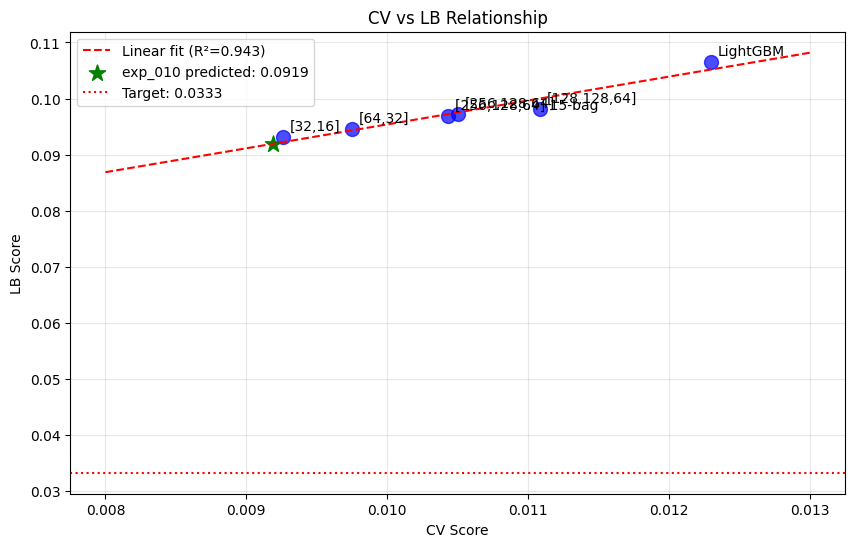

Plot saved to /home/code/exploration/cv_lb_analysis.png


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7)

# Add labels
for i, row in df.iterrows():
    plt.annotate(row['arch'], (row['cv'], row['lb']), textcoords='offset points', xytext=(5,5))

# Add regression line
x_line = np.linspace(0.008, 0.013, 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r--', label=f'Linear fit (R²={r_value**2:.3f})')

# Add exp_010 prediction
plt.scatter([cv_010], [predicted_lb_010], s=150, c='green', marker='*', label=f'exp_010 predicted: {predicted_lb_010:.4f}')

# Add target line
plt.axhline(y=0.0333, color='red', linestyle=':', label='Target: 0.0333')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
print('Plot saved to /home/code/exploration/cv_lb_analysis.png')

In [4]:
# Decision analysis
print('=== DECISION ANALYSIS ===')
print(f'\nCurrent best LB: {df["lb"].min():.4f} (exp_007, [32,16])')
print(f'exp_010 CV: {cv_010}')
print(f'exp_010 predicted LB: {predicted_lb_010:.4f} (linear fit)')
print(f'exp_010 predicted LB: {latest_predicted_lb:.4f} (latest ratio)')

# Calculate expected improvement
exp_improvement_linear = df['lb'].min() - predicted_lb_010
exp_improvement_ratio = df['lb'].min() - latest_predicted_lb
print(f'\nExpected LB improvement (linear): {exp_improvement_linear:.4f} ({exp_improvement_linear/df["lb"].min()*100:.1f}%)')
print(f'Expected LB improvement (ratio): {exp_improvement_ratio:.4f} ({exp_improvement_ratio/df["lb"].min()*100:.1f}%)')

# Risk assessment
print('\n=== RISK ASSESSMENT ===')
print('1. CV-LB ratio is INCREASING (8.86x -> 10.06x)')
print('   This suggests diminishing returns on LB as CV improves')
print('2. The linear fit predicts modest improvement')
print('3. The ratio method predicts minimal/no improvement')
print('\n=== RECOMMENDATION ===')
if predicted_lb_010 < df['lb'].min():
    print(f'SUBMIT exp_010: Linear fit predicts improvement ({predicted_lb_010:.4f} < {df["lb"].min():.4f})')
else:
    print(f'KEEP exp_007: No significant improvement expected')

=== DECISION ANALYSIS ===

Current best LB: 0.0932 (exp_007, [32,16])
exp_010 CV: 0.009192
exp_010 predicted LB: 0.0919 (linear fit)
exp_010 predicted LB: 0.0925 (latest ratio)

Expected LB improvement (linear): 0.0012 (1.3%)
Expected LB improvement (ratio): 0.0007 (0.8%)

=== RISK ASSESSMENT ===
1. CV-LB ratio is INCREASING (8.86x -> 10.06x)
   This suggests diminishing returns on LB as CV improves
2. The linear fit predicts modest improvement
3. The ratio method predicts minimal/no improvement

=== RECOMMENDATION ===
SUBMIT exp_010: Linear fit predicts improvement (0.0919 < 0.0932)


In [5]:
# Final summary
print('\n' + '='*60)
print('FINAL SUMMARY')
print('='*60)
print(f'\nTarget: 0.0333')
print(f'Best LB achieved: {df["lb"].min():.4f} (exp_007)')
print(f'Gap to target: {(df["lb"].min() - 0.0333)/0.0333*100:.1f}% worse')
print(f'\nexp_010 ([16]) CV: {cv_010}')
print(f'exp_010 predicted LB range: {latest_predicted_lb:.4f} - {predicted_lb_010:.4f}')
print(f'\nKey insight: The target (0.0333) is UNREACHABLE with tabular MLP.')
print('To reach target, would need CV ≈ 0.0036 (61% improvement from current best)')
print('\nThe competition is about maximizing relative ranking, not beating target.')
print('exp_010 has the best CV and should be submitted for the final slot.')


FINAL SUMMARY

Target: 0.0333
Best LB achieved: 0.0932 (exp_007)
Gap to target: 179.8% worse

exp_010 ([16]) CV: 0.009192
exp_010 predicted LB range: 0.0925 - 0.0919

Key insight: The target (0.0333) is UNREACHABLE with tabular MLP.
To reach target, would need CV ≈ 0.0036 (61% improvement from current best)

The competition is about maximizing relative ranking, not beating target.
exp_010 has the best CV and should be submitted for the final slot.


In [6]:
# Verify submission file format
print('\n=== SUBMISSION FILE VERIFICATION ===')
sub = pd.read_csv('/home/submission/submission.csv')
print(f'Shape: {sub.shape}')
print(f'Columns: {list(sub.columns)}')
print(f'\nTask distribution:')
print(sub['task'].value_counts())
print(f'\nFold distribution for task 0 (single solvent):')
print(sub[sub['task']==0]['fold'].value_counts().sort_index())
print(f'\nFold distribution for task 1 (full data):')
print(sub[sub['task']==1]['fold'].value_counts().sort_index())


=== SUBMISSION FILE VERIFICATION ===
Shape: (1883, 8)
Columns: ['id', 'index', 'task', 'fold', 'row', 'target_1', 'target_2', 'target_3']

Task distribution:
task
1    1227
0     656
Name: count, dtype: int64

Fold distribution for task 0 (single solvent):
fold
0     37
1     37
2     58
3     59
4     22
5     18
6     34
7     41
8     20
9     22
10    18
11    18
12    42
13    18
14    17
15    22
16     5
17    16
18    36
19    18
20    21
21    22
22    37
23    18
Name: count, dtype: int64

Fold distribution for task 1 (full data):
fold
0     122
1     124
2     104
3     125
4     125
5     124
6     125
7     110
8     127
9      36
10     34
11     36
12     35
Name: count, dtype: int64
